<a href="https://colab.research.google.com/github/bziar/pattern_recognition/blob/main/brian2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install brian2

     |████████████████████████████████| 1.5 MB 8.3 MB/s 


In [ ]:
import matplotlib.pyplot as plt
from brian2 import *
from IPython.display import clear_output
import numpy as np
import random
import pandas as pd
import matplotlib
from pathlib import Path
from PIL import Image
from IPython.core.interactiveshell import InteractiveShell
from IPython import display
from tqdm import tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
% matplotlib inline

[[0 0 1]
 [0 1 0]
 [1 0 0]]


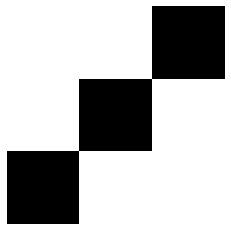

In [ ]:
def get_pattern(pattern='-', noise=0):
    if pattern == '-':
        image = np.array([0, 0, 0,
                          1, 1, 1,
                          0, 0, 0])
    elif pattern == '|':
        image = np.array([0, 1, 0,
                          0, 1, 0,
                          0, 1, 0])
    elif pattern == '/':
        image = np.array([0, 0, 1,
                          0, 1, 0,
                          1, 0, 0])
    if noise:
      image = np.ones(9) - np.fabs(np.random.rand(9)*noise + image - np.ones(9))
    # return image.reshape(-1)
    return image


seed()
plt.axis('off')
image = get_pattern(pattern='/', noise=0).reshape(3, 3)
print(image)
plt.imshow(np.ones((3,3)) - image, cmap='gray', vmin=0, vmax=1)

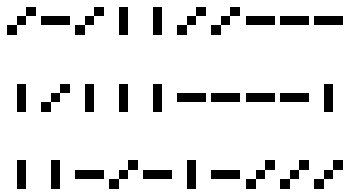

In [ ]:
fig = plt.figure()
image_number = 30
cols = 10
rows = image_number // cols + image_number % cols
position = range(1, image_number + 1)
i = 0
for pattern in random.choices(['-', '|', '/'], k=image_number):
    # print(pattern)
    ax = fig.add_subplot(rows, cols, position[i])
    ax.axis('off')
    plt.imshow(np.ones((3, 3))-get_pattern(pattern=pattern, noise=False).reshape(3, 3), cmap='gray')
    # clear_output(wait=True)
    i += 1

In [ ]:
def input_layer(image, sample_rate, t, dt):
  image = image.reshape(-1)
  output_neurons = np.zeros(image.shape)
  if (sample_rate == 1):
    indeces = np.where(image > 0)[0]
    times = np.array([t] * len(indeces))
  else:
    for i in range(sample_rate - 1):
      output_neurons += (image >= (i + 1) * (np.ones(image.shape) / sample_rate))
      indeces, times = np.array([]), np.array([])
      output_neurons = output_neurons.astype(int)
    for i in range(len(output_neurons)):
      indeces = np.append(indeces, [i] * output_neurons[i])
      times = np.append(times, [t + j*dt for j in range(output_neurons[i])])
  return indeces, times

In [ ]:
def visualise_connectivity(S):
  Ns = len(S.source)
  Nt = len(S.target)
  figure(figsize=(5, 4))
  plot(zeros(Ns), arange(Ns), 'ok', ms=10) 
  plot(ones(Nt), arange(Nt), 'ok', ms=10) 
  for i, j in zip(S.i, S.j):
    if S.w[i, j] >= 0:
      plot([0, 1], [i, j], '-k', linewidth=S.w[i, j]/max(S.w[:]), c='red')
    else:
      plot([0, 1], [i, j], '-k', linewidth=S.w[i, j]/max(S.w[:]), c='blue')
  xticks([0, 1], ['Input', 'Output'])
  ylabel('Neuron index')
  xlim(-0.1, 1.1)
  ylim(-1, max(Ns, Nt))
  

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.10s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 1.42s). [brian2.stateupdaters.base.method_choice]


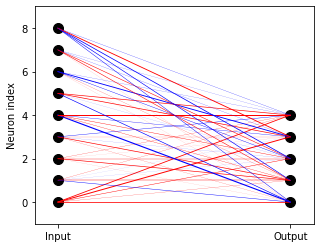

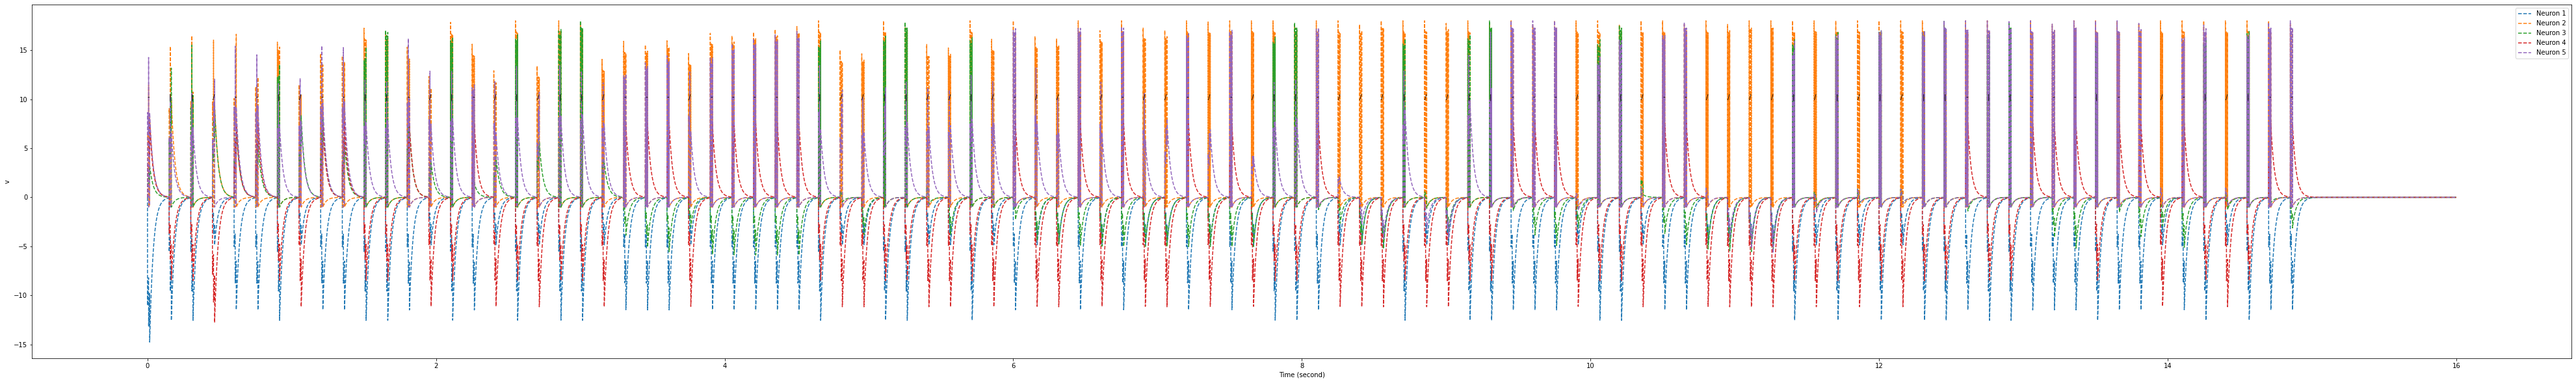

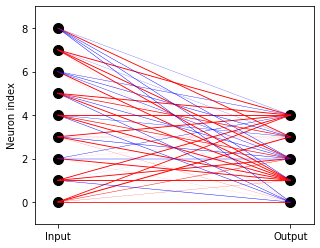

In [ ]:
start_scope()
image_number = 100
indeces, times = np.array([]), np.array([])
t = 0
delta_t = 150
patterns = random.choices(['-', '|', '/'], k=image_number)
for pattern in patterns:
  image = get_pattern(pattern=pattern, noise=0)
  i_, t_ = input_layer(image=image, sample_rate=4, t=t, dt=7.5)
  indeces = np.append(indeces, i_)
  times = np.append(times, t_)
  t+=delta_t
indeces, times = list(indeces.reshape(-1)), list(times.reshape(-1))
seed(0)

# A1 = 4.13
# A2 = 1.13
# t1 = 134.8/100*second
# t2 = 13.7/100*second

# taupre = t1
# taupost = taupre/1.5

# Apre = (A1 + A2*np.exp(-t1/t2)) #4.13
# Apost = -1.5*Apre
taupre = 70 * ms
taupost = taupre*2.5
wmax = 6
Apre = 0.4
Apost = -Apre * taupre / taupost * 1.6
v_treshold = 10
v_reset = -1
v_inh = 0
GT = 25 * ms
# y = A1*np.exp(-dt/t1) + A2*np.exp(-dt/t2)

eqs = '''
dv/dt = (I-v)/tau : 1 (unless refractory)
I:1
tau : second
'''

s_eq = '''
w:1
dapre/dt = -apre/taupre : 1 (clock-driven)
dapost/dt = -apost/taupost : 1 (clock-driven)
'''

n_input = 9
n_output = 5


P = SpikeGeneratorGroup(n_input, indices=indeces,
                        times=times * ms)

G = NeuronGroup(n_output, eqs,
                threshold='v>v_treshold',
                reset='v = v_reset')
G.I = 0
G.tau = GT

S1 = Synapses(P, G, s_eq,
              on_pre='''
              v_post += w
              apre += Apre
              w = clip(w+apost, -0.5*wmax, wmax)
              ''',
              on_post='''
              apost += Apost
              w = clip(w+apre, -0.5*wmax, wmax)
              ''')
S1.connect()
# S1.w = '0.5*rand()'
S1.w = np.random.normal(0, 3, n_input * n_output)
S1.apre = S1.apost = np.zeros(n_input * n_output)
# print(S1.w[:].reshape((n_input, n_output)))
visualise_connectivity(S1)

# S2 = Synapses(G, G, 
#               on_pre='''
#               v_post = v_inh
#               ''')
# S2.connect(condition='i!=j')

M = StateMonitor(G, 'v', record=True)
WM = StateMonitor(S1, 'w', record=True)
run((delta_t/1000 * image_number + 1)* second)
figure(figsize=(70, 10))
for k in range(n_output):
    plot(M.t / second, M.v[k], label='Neuron ' + str(k + 1), linestyle = '--')
for i in range(image_number):
  plt.text(delta_t/1000 * i, v_treshold, patterns[i])
xlabel('Time (second)')
ylabel('v')
legend()
plt.show()
visualise_connectivity(S1)

Text(0, 0.5, 'Input')

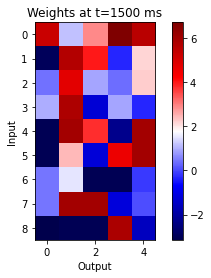

In [ ]:
imshow(WM.w[:, -1].reshape(9, 5), cmap='seismic')
title(f'Weights at t={t} ms')
colorbar()
xlabel('Output')
ylabel('Input')

In [ ]:
frames = []
# print(WM.w[:, 40000])
for t in range(0, 15500, 100):
  plt.figure(figsize=(3,3))
  plt.imshow(WM.w[:, t].reshape(9, 5), cmap='seismic')
  plt.title(f'Weights at t={t} ms')
  plt.colorbar()
  plt.xlabel('Output')
  plt.ylabel('Input')
  plt.savefig(f'plot_{t}.png', dpi=90)
  plt.close()

for t in range(0, 15500, 100):
  frame = Image.open(f'plot_{t}.png')
  frames.append(frame)

frames[0].save(
        'weights_dynamic.gif',
        save_all=True,
        append_images=frames[1:],
        optimize=True,
        duration=[100] * len(frames),
        loop=0
        )
from google.colab import files
files.download('weights_dynamic.gif') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.03s). [brian2.stateupdaters.base.method_choice]


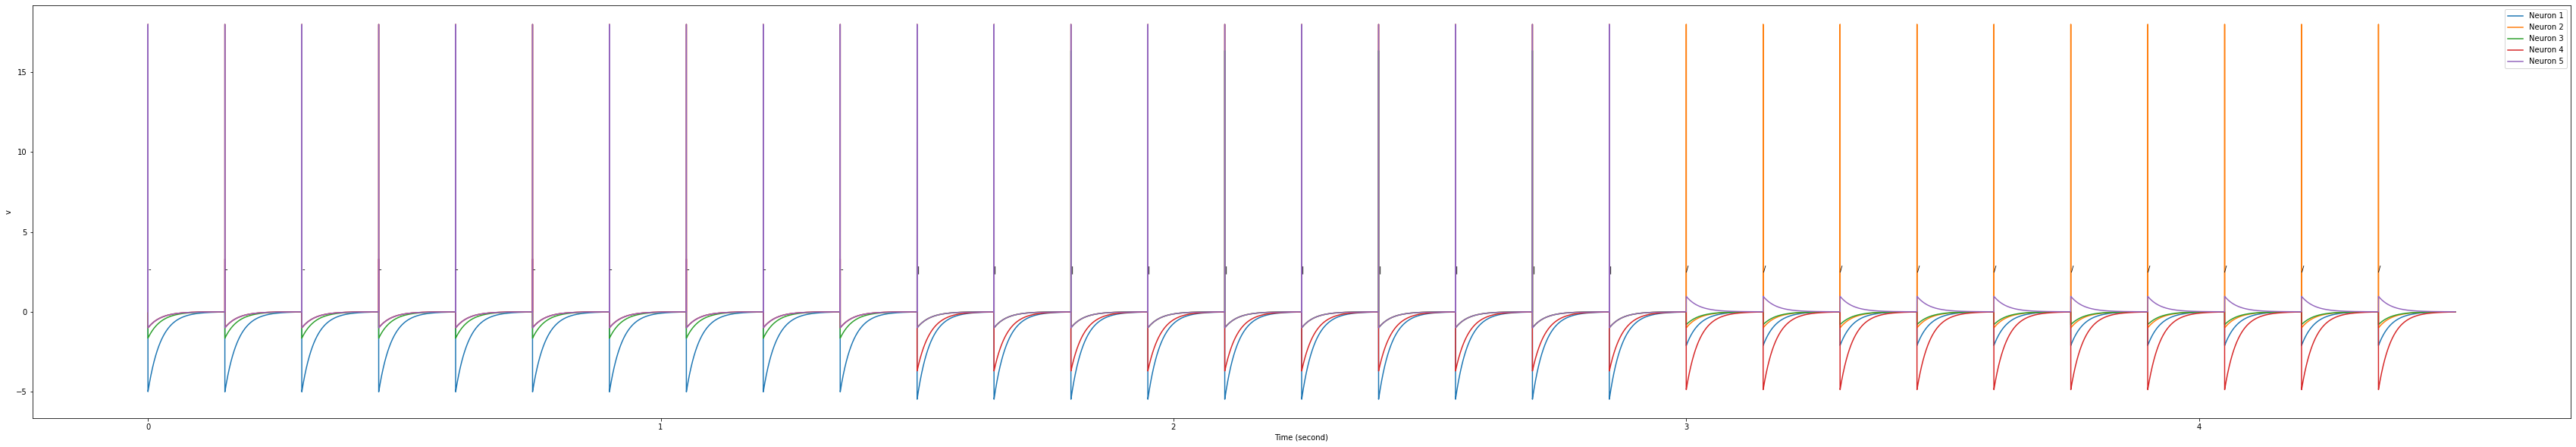

In [ ]:
start_scope()
image_number = 30
indeces, times = np.array([]), np.array([])
# patterns = random.choices(['-', '|', '/'], k=image_number)
patterns = ['-']*int(image_number/3) + ['|']*int(image_number/3) + ['/']*int(image_number/3)
t = 0
for pattern in patterns:
  image = get_pattern(pattern=pattern, noise=0)
  i_, t_ = input_layer(image=image, sample_rate=1, t=t, dt=7.5)
  indeces = np.append(indeces, i_)
  times = np.append(times, t_)
  t+=delta_t
indeces, times = list(indeces.reshape(-1)), list(times.reshape(-1))


eqs = '''
dv/dt = (I-v)/tau : 1 (unless refractory)
I:1
tau : second
'''

s_eq = '''
w:1
'''

n_input = 9
n_output = 5


P = SpikeGeneratorGroup(n_input, indices=indeces,
                        times=times * ms)
v_treshold /= 4
G = NeuronGroup(n_output, eqs,
                threshold='v>v_treshold',
                reset='v = v_reset')
G.I = 0
G.tau = GT

S_ = Synapses(P, G, s_eq,
              on_pre='''
              v_post += w
              ''')
S_.connect()

# S_.w = np.sign(S1.w[:])
S_.w = S1.w[:]

# S2 = Synapses(G, G, 
#               on_pre='''
#               v_post = v_inh
#               ''')
# S2.connect(condition='i!=j')

M = StateMonitor(G, 'v', record=True)
SM = SpikeMonitor(G, 'v', record=True)
run((delta_t/1000 * image_number)* second)
figure(figsize=(60, 10))
for k in range(n_output):
    plot(M.t / second, M.v[k], label='Neuron ' + str(k + 1))
for i in range(image_number):
  plt.text(delta_t/1000 * i, v_treshold, patterns[i])
xlabel('Time (second)')
ylabel('v')
legend()
plt.show()

In [ ]:
results = {}
for i in range(5):
  print(f'Pattern - , neuron {i}, ', len([t for t in SM.all_values()['t'][i]/ms if t <=image_number*delta_t/3 - 50]))
print('='*30)
for i in range(5):
  print(f'Pattern | , neuron {i}, ', len([t for t in SM.all_values()['t'][i]/ms if (image_number*delta_t/3 - 50 <= t and t <= image_number*delta_t*2/3-50)]))
print('='*30)
for i in range(5):
  print(f'Pattern / , neuron {i}, ', len([t for t in SM.all_values()['t'][i]/ms if image_number*delta_t*2/3-50 <= t]))

Pattern - , neuron 0,  0
Pattern - , neuron 1,  0
Pattern - , neuron 2,  0
Pattern - , neuron 3,  10
Pattern - , neuron 4,  10
Pattern | , neuron 0,  0
Pattern | , neuron 1,  10
Pattern | , neuron 2,  10
Pattern | , neuron 3,  0
Pattern | , neuron 4,  0
Pattern / , neuron 0,  0
Pattern / , neuron 1,  10
Pattern / , neuron 2,  0
Pattern / , neuron 3,  0
Pattern / , neuron 4,  10
